## 16.1 Metric overview

The metrics we are going to consider in this chapter that are generally used to evaluate machine learning models include accuracy, precision, recall, F1 score, and the area under the ROC curve.
- Accuracy measures how often the model correctly predicts the target class.
- Precision measures how often the model is correct when it predicts the positive class.
- Recall measures how often the model can correctly identify the positive class.
- The area under the ROC curve is one measure to balance precision and recall.
- The F1 score combines both precision and recall by using their harmonic mean.

These metrics help to evaluate a model's performance and choose the right metric for a specific problem.

In [2]:
import dtreeviz
from feature_engine import encoding, imputation
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import base, compose, datasets, ensemble, metrics, model_selection, pipeline, preprocessing, tree
import scikitplot
import xgboost as xgb
import yellowbrick.model_selection as ms
from yellowbrick import classifier
import urllib
import zipfile
from hyperopt import fmin, tpe, hp, Trials
from EffectiveXGBoost import *

In [4]:
path_url = 'https://github.com/mattharrison/datasets/raw/master/data/kaggle-survey-2018.zip'
file_name = 'kaggle-survey-2018.zip'
dataset = 'multipleChoiceResponses.csv'

raw = extract_dataset(path_url, file_name, dataset)

# Create raw X and raw y
kag_X, kag_y = prepX_y(raw, 'Q6')

# Split data
kag_X_train, kag_X_test, kag_y_train, kag_y_test = (model_selection
                                                    .train_test_split(kag_X, 
                                                                      kag_y, 
                                                                      test_size=.3, 
                                                                      random_state=42, 
                                                                      stratify=kag_y)
                                                   )


# Transform X with pipeline
pline = pipeline.Pipeline(
    [('tweak', PrepDataTransformer()),
    ('cat', encoding.OneHotEncoder(top_categories=5, drop_last=True,
    variables=['Q1', 'Q3', 'major'])),
    ('num_impute', imputation.MeanMedianImputer(imputation_method='median',
                variables=['education', 'years_exp']))]
    )

X_train = pline.fit_transform(kag_X_train)
X_test = pline.transform(kag_X_test)

# Transform y with label encoder
label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(kag_y_train)
y_train = label_encoder.transform(kag_y_train)
y_test = label_encoder.transform(kag_y_test)

# Combined Data for cross validation/etc
X = pd.concat([X_train, X_test], axis='index')
y = pd.Series([*y_train, *y_test], index=X.index)

# Default training
xg = xgb.XGBClassifier()
xg.fit(X_train, y_train)

G:\My Drive\SisengAI\AlgorithmicTrading\code_rebuilding\MattHarrison\EffectiveXGBoost\EffectiveXGBoost_MyTake\EffectiveXGBoost.py:62: DtypeWarning: Columns (0,2,8,10,21,23,24,25,26,27,28,44,56,64,83,85,87,107,109,123,125,150,157,172,174,194,210,218,219,223,246,249,262,264,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,304,306,325,326,329,341,368,371,384,385,389,390,391,393,394) have mixed types. Specify dtype option on import or set low_memory=False.


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

## 16.2 Training with Validation Curves

In [10]:
from yellowbrick import model_selection as ms

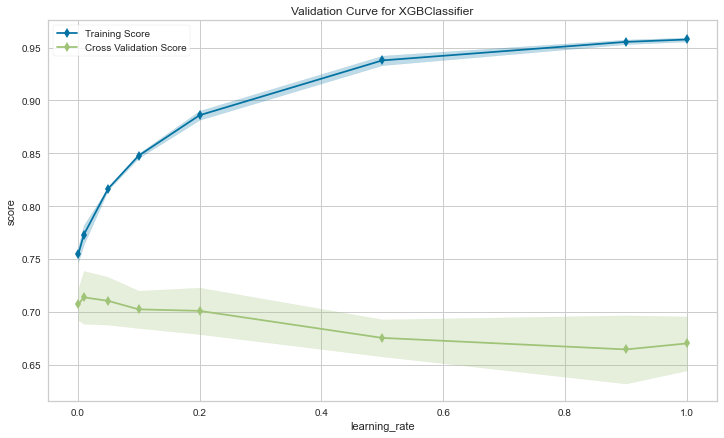

Text(0.5, 17.246875000000003, 'Accuracy')

In [14]:
fig, ax = plt.subplots(figsize=(12, 7))
ms.validation_curve(xgb.XGBClassifier(), X_train, y_train,
    scoring='accuracy', param_name='learning_rate',
    param_range=[0.001, .01, .05, .1, .2, .5, .9, 1], ax=ax)
ax.set_xlabel('Accuracy')

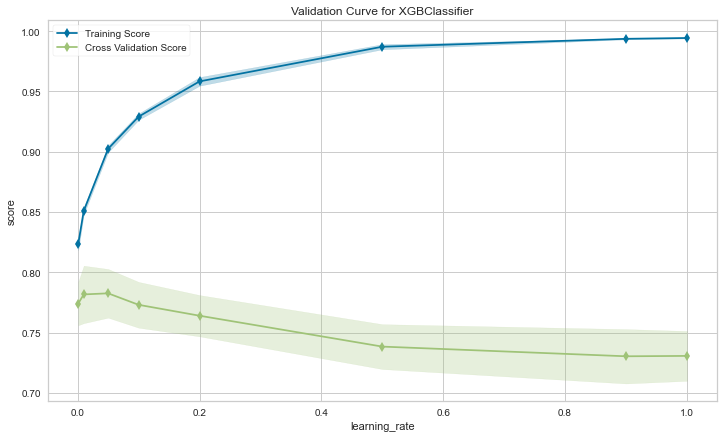

Text(0.5, 17.246875000000003, 'roc_auc')

In [15]:
fig, ax = plt.subplots(figsize=(12, 7))
ms.validation_curve(xgb.XGBClassifier(), X_train, y_train,
    scoring='roc_auc', param_name='learning_rate',
    param_range=[0.001, .01, .05, .1, .2, .5, .9, 1], ax=ax
)
ax.set_xlabel('roc_auc')

## 16.3 Step-wise Recall Tuning


In [16]:
from sklearn.metrics import roc_auc_score
from hyperopt import hp, Trials, fmin, tpe

In [18]:
params = {'random_state': 42}

rounds = [{'max_depth': hp.quniform('max_depth', 1, 9, 1), # tree
    'min_child_weight': hp.loguniform('min_child_weight', -2, 3)},
    {'subsample': hp.uniform('subsample', 0.5, 1), # stochastic
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1)},
    {'gamma': hp.loguniform('gamma', -10, 10)}, # regularization
    {'learning_rate': hp.loguniform('learning_rate', -7, 0)} # boosting
    ]
for round in rounds:
    params = {**params, **round}
    trials = Trials()
    best = fmin(fn=lambda space: hyperparameter_tuning(
        space, X_train, y_train, X_test, y_test, metric=roc_auc_score),
        space=params,
        algo=tpe.suggest,
        max_evals=40,
        trials=trials,
        )
    
params = {**params, **best}

100%|███████████████████████████████████████████████| 40/40 [00:09<00:00,  4.35trial/s, best loss: -0.7589320015366885]


In [19]:
xgb_def = xgb.XGBClassifier()
xgb_def.fit(X_train, y_train)
metrics.roc_auc_score(y_test, xgb_def.predict(X_test))

0.7451313573096131

The training above gives the following parameters

In [25]:
params['max_depth'] = int(params['max_depth'])
params

{'random_state': 42,
 'max_depth': 7,
 'min_child_weight': 2.3567517599965226,
 'subsample': 0.7096452549552429,
 'colsample_bytree': 0.5972135962796586,
 'gamma': 0.00038220212038342827,
 'learning_rate': 0.015416582685690093}

Below I use the `'verbose=100'` parameter to only show the output every 100 iterations.

In [26]:
xgb_tuned = xgb.XGBClassifier(**params, early_stopping_rounds=50,
  n_estimators=500)

xgb_tuned.fit(X_train, y_train, eval_set=[(X_train, y_train),
 (X_test, y_test)], verbose=100)

[0]	validation_0-logloss:0.68985	validation_1-logloss:0.69037
[100]	validation_0-logloss:0.52259	validation_1-logloss:0.54020
[200]	validation_0-logloss:0.47459	validation_1-logloss:0.50970
[300]	validation_0-logloss:0.44892	validation_1-logloss:0.49936
[400]	validation_0-logloss:0.43086	validation_1-logloss:0.49586
[442]	validation_0-logloss:0.42484	validation_1-logloss:0.49625


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.5972135962796586, early_stopping_rounds=50,
              enable_categorical=False, eval_metric=None,
              gamma=0.00038220212038342827, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.015416582685690093, max_bin=256,
              max_cat_to_onehot=4, max_delta_step=0, max_depth=7, max_leaves=0,
              min_child_weight=2.3567517599965226, missing=nan,
              monotone_constraints='()', n_estimators=500, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, ...)

In [27]:
metrics.roc_auc_score(y_test, xgb_tuned.predict(X_test))

0.7582892520464551

I love this improvement.

## Summary

- The purpose of a validation curve is to determine training and test scores for varying parameter values. It computes scores for an estimator with different values of a specified parameter. This is similar to grid search with one parameter. However, this will also compute training scores and is merely a utility for plotting the results.
- Tuning a model for recall differs from tuning for accuracy because recall and accuracy are different metrics that measure different aspects of a model's performance. Recall measures the proportion of true positive instances that were correctly identified by the model, while accuracy measures the proportion of all instances that were correctly classified. As a result, optimizing for one metric may not necessarily optimize for the other.
- The choice of metric can influence a model's hyperparameters because different metrics may require different hyperparameter settings to achieve optimal performance. For example, if you are optimizing for recall, you may need to adjust the hyperparameters in a way that increases the true positive rate, even if it means sacrificing some precision.
- It is possible to optimize a model for both precision and recall simultaneously, but there is often a trade-off between the two. This trade-off can be visualized using a precision-recall curve, which shows how precision and recall change as the decision threshold is varied. The goal is to find a balance between precision and recall that achieves good performance on both metrics.
- It might be important to prioritize recall over precision or vice versa depending on the specific problem you are trying to solve. For example, in a medical diagnosis scenario where failing to identify a disease could have serious consequences, it may be more important to prioritize recall (i.e., correctly identifying all positive cases) even if it means sacrificing some precision (i.e., having more false positives). On the other hand, in a spam email classification scenario where incorrectly classifying an email as spam could result in lost business opportunities, it may be more important to prioritize precision (i.e., minimizing false positives) even if it means sacrificing some recall (i.e., having more false negatives).
